# DAWN Winter School 2022 
### - Spectral Analysis Tools Tutorial

This tutorial will show and provide the basics of analyzing and extracting physical properties from astronomical spectra. In this example, we will first work with a VIS arm spectrum (560-1024 nm) from the X-shooter echelle spectrograch at the ESO Very Large Telescope in Chile of the host galaxy of the gamma-ray burst (GRB) 031203.
This tutorial will mostly rely on AstroPy's SpecUtils (https://specutils.readthedocs.io/en/stable/) module available in Python, but other tools also exist:
- LineTools (Python: https://linetools.readthedocs.io/en/latest/)
- splot (IRAF: https://iraf.net/)

Some of these allow more quick view-and-analysis of the data with interactive GUIs, but for the sake of transparancy this tutorial shows all the necessary steps involved in basic spectroscopic analysis. 
This tutorial will focus on emission-line galaxy spectra -- see the other tutorial for an example of how-to analyze absorption-line spectra.

In [5]:
# Load in the necessary basic modules 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from lmfit import Model
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDWebQuery
import extinction

# Load in the relevant specutils functionalities
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum
from astropy.modeling.polynomial import Polynomial1D, Chebyshev1D
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.fitting import fit_lines, estimate_line_parameters

In [ ]:
# First, we need to read in the spectroscopic data
dat = np.genfromtxt('HG031203_VIS.txt')
wave = dat[:,0] * u.AA  # First data column is the wavelength of the spectrum in units of Ångstrom (Å)
flux = dat[:,1] * u.Unit('erg s-1 cm-2 AA-1')# Second data column is the flux density in unis of erg s^-1 cm^-2 Å^-1 

# One of the very first things to check is whether your spectrum has been corrected by the Galactic extinction due to dust. If *not*, we can do it like this
# First input coordinates and define frame
coords = SkyCoord('08h02m30.2s', '-39d51m03.9s', frame='icrs')

# Query the E(B-V) value from the MW dust maps of Schlegel, Finkbeiner & Davis (1998):
sfd = SFDWebQuery()
EBV = sfd(coords)

print('E(B-V) = {:.3f} mag'.format(EBV))

# Convert to visual extinction, AV = E(B-V) * R_V, where average R_V = 3.1 for the MW
AV = EBV * 3.1

# Determine the wavelength-dependent extinction given the A_V
Al = extinction.fm07(wave, AV)

# Correct observed flux
new_flux = flux * 10**(Al/2.5)

# We can then plot the spectrum
plt.step(wave,new_flux)
# Setting title and axis labels
plt.title('GRB031203 host')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# With sensible x and y ranges
plt.xlim(5600,9300)
plt.ylim(-0.1e-16,5e-16)

In [7]:
# Then for the sake of this exercise we need to re-format this dataset and create a Spectrum1D object
spec = Spectrum1D(spectral_axis=wave, flux=new_flux)
# Which we can also use to plot the spectrum following their format
plt.step(spec.spectral_axis, spec.flux) 

# Setting the same title and axis labels
plt.title('GRB031203 host')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# With sensible x and y ranges
plt.xlim(5600,9300)
plt.ylim(-0.1e-16,5e-16)

NameError: name 'new_flux' is not defined

In [ ]:
# As a first attempt in analyzing this spectrum we can normalize it by fitting a model to the continuum flux
# SpecUtils "fit_generic_continuum" function by default first smoothes the spectrum with a median filter to remove spikes (typically emission lines) and then fits a 3rd order Chebyshev polynomial to the input (set to 1st order for this example)
# If there is a physically motivated form of the continuum spectrum the spectrum can also be modelled with this directly
cont_norm_spec = spec / fit_generic_continuum(spec,model=Chebyshev1D(1))(spec.spectral_axis) 

# Plot the normalized spectrum
plt.step(cont_norm_spec.wavelength, cont_norm_spec.flux)  
# With sensible x and y ranges
plt.xlim(5600,9300)
plt.ylim(-1,3)


In [ ]:
# For a clearer vizualization we can smooth the spectrum (here by a factor of 10)
# First we define the smoothing function
def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

# Smooth flux by a factor of 10
flux_bin = smooth(cont_norm_spec.flux,20)
# Plot (again) the normalized spectrum
plt.step(cont_norm_spec.wavelength, flux_bin)  
# With sensible x and y ranges
plt.xlim(5600,9300)
plt.ylim(-1,3)

In [ ]:
# Zooming in on an emission line ([NII] and H-alpha at z=0.1055)
plt.step(cont_norm_spec.wavelength, cont_norm_spec.flux)  
halpha_wl = 6564.61 # Wavelength of H-alpha in rest-frame
xlow = halpha_wl * (1+0.1055) - 30
xhigh = halpha_wl * (1+0.1055) + 30
plt.xlim(xlow,xhigh)  
plt.ylim(-1,200)

In [ ]:
# We can then first measure the equivalent width (EW) of the H-alpha line
EW = np.abs(equivalent_width(cont_norm_spec, regions=SpectralRegion(7245 * u.AA, 7265 * u.AA)))
print(EW)

The definition of EW is $W_\lambda = \int (1-F_\lambda/F_0)d\lambda$, where $F_0$ is the continuum flux ($F_0 = 1$ in this case) and $F_\lambda$ represents the flux across the entire wavelength range of interest. It is possible to both calculate the EW of an emission or an absorption line, but by definition $W_\lambda$ will be negative for emission lines, so we output the absolute value.

### Measuring line fluxes and widths

Now we have read in a typical galaxy spectrum, fitted the continuum and measured the equivalent width for a single line (H-alpha). However, key physical properties about galaxies are typically measured from the *line fluxes* of (several) emission lines. We will measure the line fluxes and widths of the most prominent nebular emission lines: H$\alpha$, H$\beta$, [OIII]-5008, [NII]-65??, and the [OII]-3726,3729 doublet. These transitions allow us to infer the global star-formation rate, ionization state, and metallicity of the galaxy.   

In [3]:
# Fit the spectrum (first H-alpha) with a Gaussian line profile
# First we define a Gaussian model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

def cont(x, m, b):
    """Defines the slope and intercept of the continuum flux"""
    return m*x + b

# Load wave and flux to dimensionless quantities (for the fit)
x = (spec.spectral_axis).value
y = (spec.flux).value

# Read in model + specify input values
gmodel = Model(gaussian) + Model(cont)
# Define the model parameters results + initial guesses
result = gmodel.fit(y, x=x, amp=8e-15, cen=7253, wid=2, m=-2e-20, b=2e-16, nan_policy='omit',method='leastsq')
# Print the best-fit paramters
# Here, amp = the line flux, cen = centroid of the line, and wid = the standard deviation of the function in Å
print(result.fit_report())

# Plot the spectrum centred on H-alpha
plt.plot(x, y, 'o')
plt.xlim(xlow,xhigh)  
plt.ylim(-0.1e-16,5e-15)
# Plot the initial guess and the best-fit model
plt.plot(x, result.init_fit, '--', label='initial fit')
plt.plot(x, result.best_fit, '-', label='best fit')

NameError: name 'spec' is not defined

In [4]:
# Now we can extract the best-fit parameters into the physical quantities we are interested in
ha_lflux = result.params['amp'].value
ha_lflux_err = result.params['amp'].stderr
print('H-alpha line flux, F_Ha = ',ha_lflux,' +/- ',ha_lflux_err, ' erg s^-1 cm^-2')

# And determine the redshift of the line
ha_zsp = result.params['cen'].value / halpha_wl - 1.
print('Redshift of H-alpha = ',ha_zsp)

# And the FWHM width of the line, related to "wid" or the S.D. as FWHM = 2*sqrt(2*ln(2))*wid ~ 2.355*wid.}
ha_fwhm = 2 * np.sqrt(2*np.log(2)) * result.params['wid'].value 
print('FWHM of H-alpha = ',ha_fwhm,' AA')

NameError: name 'result' is not defined

### Measuring the star-formation rate

From this H$\alpha$ line measurement alone, we can thus already say something about the redshift and the dynamics of the galaxy. From this single line measurement we can further infer the star-formation rate (SFR) of the galaxy, following the relation SFR ($M_\odot$/yr) = $7.9\times 10^{-42} L_{\rm H\alpha}$ (erg/s) from Kennicutt 1998 (https://ui.adsabs.harvard.edu/abs/1998ARA%26A..36..189K/abstract). Here $L_{\rm H\alpha}$ is the H$\alpha$ line luminosity, related to the line flux via: $L_{\rm H\alpha} = F_{\rm H\alpha} \times 4 \pi d^2_L$, where $d_L$ is the luminosity distance at the measured redshift. We know that only the most short-lived (<20 Myr) and massive (>10 $M_\odot$) stars contribute significantly to the integrated ionizing flux. The H$\alpha$ emission therefore provides a nearly instantaneous measure of the SFR.

In [241]:
# Compute luminosity distance at H-alpha redshift, using astropy's cosmology tools
d_L = cosmo.luminosity_distance(ha_zsp)
print('d_L = ',d_L)

# This we need to convert to cm to make the units add up for the L_Ha -> SFR calibration
d_L_cm = d_L.to(u.cm) 
print('d_L = ',d_L_cm)

# Computing the H-alpha line luminosity
ha_lum = ha_lflux * (u.erg / u.s / u.cm**2)  * 4 * np.pi * d_L_cm**2
print('H-alpha line luminosity = ',ha_lum, ' +/- ',ha_lum * ha_lflux_err/ha_lflux)

# We can then infer the SFR 
sfr = 7.9e-42 * (u.Msun / u.yr) / (u.erg / u.s) * ha_lum 
print(sfr)

d_L =  502.5548073224385 Mpc
d_L =  1.550722102425562e+27 cm
H-alpha line luminosity =  4.349045235866611e+41 erg / s  +/-  2.5037068829709807e+41 erg / s
3.435745736334623 solMass / yr


### Measuring the gas-phase metallicity

Next, we want to measure the gas-phase metallicity of the galaxy based on the available emission lines, via so-called strong-line diagnostics or strong-line calibrations. There is a long literature on this approach (see e.g. Kewley & Ellison 2008: https://ui.adsabs.harvard.edu/abs/2008ApJ...681.1183K/abstract; Kewley et al. 2019: https://ui.adsabs.harvard.edu/abs/2019ARA%26A..57..511K/abstract; Maiolino & Mannucci 2019: https://ui.adsabs.harvard.edu/abs/2019A%26ARv..27....3M/abstract). 

For the sake of this exercise we will derive the metallicity using only one calibration, namely N2 = log[([NII]$\lambda$6584/H$\alpha$)], from Kewley & Ellsion's PP04 N2 calibrations. This is by no means necessarily the most accurate, but is easy and simple for us to measure for this exercise. It also has the advantage that the two line-ratio terms are close in wavelength space, making e.g. extinction due to dust a negligible issue. 

[[Model]]
    (Model(gaussian) + Model(cont))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 38907
    # variables        = 6
    chi-square         = 2.4834e-24
    reduced chi-square = 6.3838e-29
    Akaike info crit   = -2525883.17
    Bayesian info crit = -2525831.75
[[Variables]]
    amp_ha:   1.4350e-14 +/- 8.2262e-15 (57.32%) (init = 2e-14)
    amp_nii:  4.6362e-16 +/- 6.7173e-15 (1448.87%) (init = 2e-15)
    zsp:      0.10525292 +/- 1.5923e-04 (0.15%) (init = 0.105)
    wid:      1.56751300 +/- 1.04565791 (66.71%) (init = 1.5)
    m:       -2.2265e-20 +/- 2.8858e-20 (129.61%) (init = -2e-20)
    b:        2.0679e-16 +/- 2.2786e-16 (110.19%) (init = 2e-16)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b)        = -0.984
    C(amp_ha, wid) = 0.578


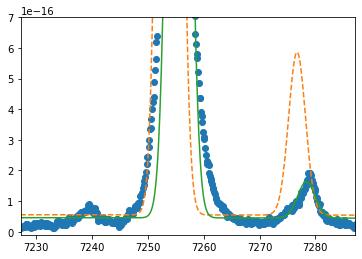

In [242]:
# Fit the spectrum (H-alpha + [NII]) with a double Gaussian line profile
# Define rest-frame wavelengths
ha_wl = 6564.61
nii_wl = 6585.27

# Define the double Gaussian model
# In this step, we assume that the redshift and the line width of the two emission lines are consistent. This is physically motivated since we know they originate from the same gas.
def gaussian(x, amp_ha, amp_nii, zsp, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp_ha / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-((1+zsp)*ha_wl))**2 / (2*wid**2)) \
            + (amp_nii / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-((1+zsp)*nii_wl))**2 / (2*wid**2))

# Define model for continuum
def cont(x, m, b):
    """Defines the slope and intercept of the continuum flux"""
    return m*x + b

# Load wave and flux to dimensionless quantities (for the fit)
x = (spec.spectral_axis).value
y = (spec.flux).value

# Read in model + specify input values
gmodel = Model(gaussian) + Model(cont)
# Define the model parameters results + initial guesses
result = gmodel.fit(y, x=x, amp_ha=2e-14, amp_nii=2e-15, zsp=0.105, wid=1.5, m=-2e-20, b=2e-16, nan_policy='omit',method='leastsq')
# Print the best-fit paramters
print(result.fit_report())

# Plot the spectrum centred on H-alpha, but scaled to view [NII]
plt.plot(x, y, 'o')
plt.xlim(xlow,xhigh)  
plt.ylim(-0.1e-16,7e-16)
# Plot the initial guess and the best-fit model
plt.plot(x, result.init_fit, '--', label='initial fit')
plt.plot(x, result.best_fit, '-', label='best fit')

In [243]:
# Now we can extract the best-fit parameters into the physical quantities we are interested in
ha_lflux = result.params['amp_ha'].value
ha_lflux_err = result.params['amp_ha'].stderr
nii_lflux = result.params['amp_nii'].value
nii_lflux_err = result.params['amp_nii'].stderr
print('H-alpha line flux, F_Ha = ',ha_lflux,' +/- ',ha_lflux_err, ' erg s^-1 cm^-2')
print('[NII] line flux, F_[NII] = ',nii_lflux,' +/- ',nii_lflux_err, ' erg s^-1 cm^-2')

# And determine the redshift of the line
zsp = result.params['zsp'].value
print('Redshift of H-alpha + [NII] = ',zsp)

# And the FWHM width of the line, related to "wid" or the S.D. as FWHM = 2*sqrt(2*ln(2))*wid ~ 2.355*wid
fwhm = 2 * np.sqrt(2*np.log(2)) * result.params['wid'].value 
print('FWHM of H-alpha + [NII] = ',ha_fwhm,' AA')

# Ratio of the two line fluxes
n2 = nii_lflux / ha_lflux
log_n2 = np.log10(n2)

# Which we use to determine the gas-phase oxygen abundance, quantified as 12+log(O/H) 
logOH = 9.37 + 2.03*log_n2 + 1.26*log_n2**2 + 0.32*log_n2**3
print('12+log(O/H) = ',logOH)
# Relative to the solar abundance of 12+log(O/H) = 8.69, this metallicity is only
print('Relative abundance = ',10**(logOH-8.69),'% of solar')


H-alpha line flux, F_Ha =  1.435014602245821e-14  +/-  8.226209755049965e-15  erg s^-1 cm^-2
[NII] line flux, F_[NII] =  4.636242508436203e-16  +/-  6.717307113137677e-15  erg s^-1 cm^-2
Redshift of H-alpha + [NII] =  0.10525292368352704
FWHM of H-alpha + [NII] =  3.714612325622142  AA
12+log(O/H) =  8.083801685040628
Relative abundance =  0.24762910331393076 % of solar


### Concluding remarks

This turorial has hopefully taught you to extract and derive basic galaxy properties from emission-line spectra, including measuring EWs, redshifts, line fluxes, dust-correction and smoothing the observed spectrum. All can be done in Python using simple core modules developed for the astronomy community, and can therefore be easily expanded and modified to your needs. 

### Additional exercises

1. Try and read in the X-shooter UVB spectrum and correct the observed flux for Galactic extinction
2. Measure the line fluxes of H$\beta$ ($\lambda_{\rm rest} = 4862.68$ Å), [OIII]$\lambda 5008.240$ and the doublet [OII]$\lambda 3727.092, 3729.875$
3. Determine the ionization parameter of this galaxy, quantified via the [OIII]/[OII] line ratio
4. Where does this galaxy fall in the Baldwin-Phillips-Terlevich (BPT) diagram (i.e. in log[OIII]/H$\beta$ vs log[NII]/H$\alpha$)? Are the line ratios consistent with AGN or star formation? (see e.g. demarcation line from Kewley et al. 2013: https://ui.adsabs.harvard.edu/abs/2013ApJ...774..100K/abstract) 
5. Calculate the internal galaxy extinction $A_V$ based on the Balmer decrement, i.e. H$\alpha$/H$\beta$. The theoretical expectation $r_{\rm theo}$ for a given electron temperature (typically assumed to be $T = 10^4$ K) is $r_{\rm theo}$ = H$\alpha$ / H$\beta$ = 2.87. $A_V$ can then be estimated from: $A_V = \frac{-2.5\log(r_{\rm obs}/r_{\rm theo})}{A_{\rm H\alpha} - A_{\rm H\beta}}$
